In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_stock_data_yahoo():
    stock = pd.read_csv('data/yahoo_stock.csv')
    stock.set_index('Date', inplace=True)
    return stock['Close']

In [4]:
def get_stock_data_yahoo2():
    stock = pd.read_csv('data/yahoo_stock.csv')
    return stock

In [5]:
stock = get_stock_data_yahoo2()

In [6]:
stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [7]:
def prepare_sequences(data, sequence_length=60):
    # Initialize scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Reshape and scale the data
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])

    # Convert to float32 for better compatibility
    return (np.array(X, dtype=np.float32),
            np.array(y, dtype=np.float32),
            scaler)  # Return the entire scaler object

In [8]:
def setup_model():
    model_name = "t5-small"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    model.to(device)
    return model, tokenizer

In [9]:
def prepare_input(sequence, tokenizer):
    # Convert sequence to string with reduced precision
    sequence_str = ' '.join([f"{x[0]:.3f}" for x in sequence])
    input_text = f"predict next: {sequence_str}"

    # Tokenize and ensure correct tensor type
    encoded = tokenizer(
        input_text,
        padding='max_length',
        max_length=512,
        truncation=True,
        return_tensors="pt"
    )

    # Convert input_ids and attention_mask to long
    encoded = {k: v.long().to(device) for k, v in encoded.items()}
    return encoded

In [10]:
def prepare_target(value, tokenizer):
    target_str = f"{value[0]:.3f}"
    encoded = tokenizer(
        target_str,
        padding='max_length',
        max_length=8,
        truncation=True,
        return_tensors="pt"
    )
    return encoded.input_ids.long().to(device)

In [11]:
def train_model(model, tokenizer, X_train, y_train, epochs=5):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    batch_size = 32
    n_batches = len(X_train) // batch_size

    for epoch in range(epochs):
        total_loss = 0
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size

            batch_X = X_train[start_idx:end_idx]
            batch_y = y_train[start_idx:end_idx]

            optimizer.zero_grad()
            batch_loss = 0

            for j in range(len(batch_X)):
                inputs = prepare_input(batch_X[j], tokenizer)
                target_ids = prepare_target(batch_y[j], tokenizer)

                outputs = model(**inputs, labels=target_ids)
                batch_loss += outputs.loss

            batch_loss = batch_loss / len(batch_X)
            batch_loss.backward()
            optimizer.step()

            total_loss += batch_loss.item()

        avg_loss = total_loss / n_batches
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

    return model

In [12]:
def predict(model, tokenizer, sequence):
    model.eval()
    with torch.no_grad():
        inputs = prepare_input(sequence, tokenizer)
        outputs = model.generate(**inputs, max_length=8)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        try:
            return float(prediction)
        except ValueError:
            return None

In [13]:
def evaluate_predictions(predictions, actual_values):
    predictions = np.array(predictions)
    actual_values = np.array(actual_values)

    mae = np.mean(np.abs(predictions - actual_values))
    rmse = np.sqrt(np.mean((predictions - actual_values) ** 2))

    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Square Error: {rmse:.2f}")

    return mae, rmse


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1, Average Loss: 2.6303
Epoch 2, Average Loss: 0.7665
Epoch 3, Average Loss: 0.5628
Epoch 4, Average Loss: 0.5374
Epoch 5, Average Loss: 0.5173
Mean Absolute Error: 30.14
Root Mean Square Error: 53.64


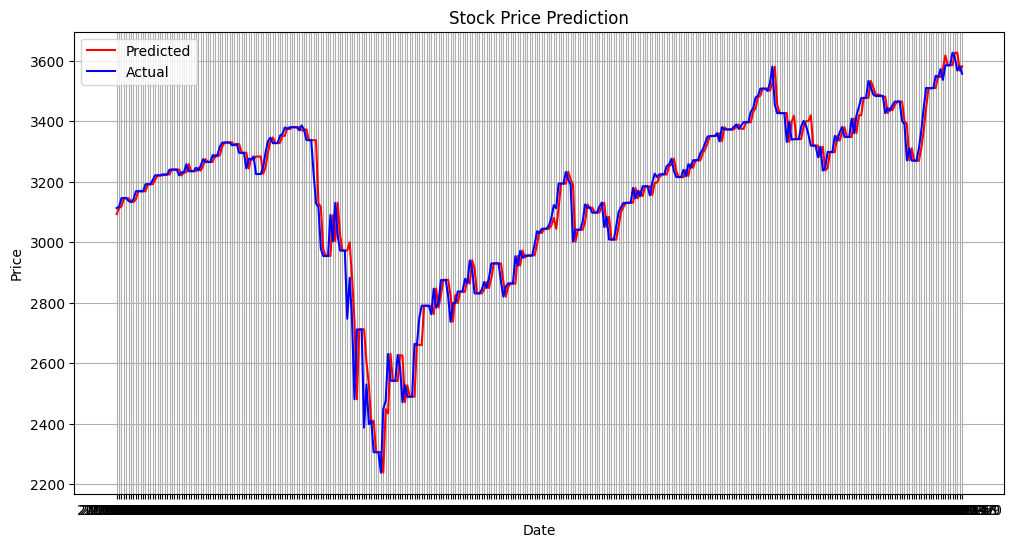

In [14]:
def main():
    # Get and prepare data
    data = get_stock_data_yahoo()
    X, y, scaler = prepare_sequences(data)

    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Setup and train model
    model, tokenizer = setup_model()
    trained_model = train_model(model, tokenizer, X_train, y_train)

    # Make predictions
    predictions = []
    for sequence in X_test:
        pred = predict(trained_model, tokenizer, sequence)
        if pred is not None:
            predictions.append(pred)

    # Convert predictions back to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    actual_values = scaler.inverse_transform(y_test)

    # Evaluate predictions
    mae, rmse = evaluate_predictions(predictions, actual_values)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-len(predictions):], predictions, label='Predicted', color='red')
    plt.plot(data.index[-len(predictions):], actual_values, label='Actual', color='blue')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()